# This file is for parsing and creating a dataset from the HDFS traces

## Let's start by importing the set and transforming it

In [5]:
import pandas as pd
import numpy as np
import random
from typing import Tuple
from cache import Cache

In [6]:
HDFS_DIR = "../data/HDFS_v1"
SEED = 2137

CACHE = Cache()

In [3]:
df = pd.read_csv(HDFS_DIR + "/preprocessed/Event_traces.csv")
print(df["Features"])

num_negative = df[df["Label"] == "Fail"]["Features"].count()
num_positive = df[df["Label"] == "Success"]["Features"].count()
print(f"positive: {num_positive}, negative: {num_negative}, total: {num_negative + num_positive}")

0         [E5,E22,E5,E5,E11,E11,E9,E9,E11,E9,E26,E26,E26...
1         [E5,E5,E22,E5,E11,E9,E11,E9,E11,E9,E26,E26,E26...
2         [E5,E22,E5,E5,E11,E9,E11,E9,E11,E9,E3,E26,E26,...
3         [E5,E22,E5,E5,E11,E9,E11,E9,E11,E9,E26,E26,E26...
4         [E5,E5,E22,E5,E11,E9,E11,E9,E11,E9,E26,E26,E26...
                                ...                        
575056    [E5,E22,E5,E5,E26,E11,E9,E11,E9,E11,E9,E26,E26...
575057    [E5,E22,E5,E5,E11,E9,E26,E11,E9,E11,E9,E26,E26...
575058    [E5,E5,E5,E22,E11,E9,E11,E9,E11,E9,E26,E26,E26...
575059    [E5,E5,E5,E22,E11,E9,E11,E9,E11,E9,E26,E26,E26...
575060    [E5,E5,E5,E22,E11,E9,E11,E9,E11,E9,E28,E26,E28...
Name: Features, Length: 575061, dtype: object
positive: 558223, negative: 16838, total: 575061


In [7]:
def parse_trace(trace_str: str) -> list[int]:
    """Parses a trace like '[E5,E5,E29]' into a list of integers [5, 5, 29]."""
    return [int(event[1:]) for event in trace_str.strip('[]').split(',') if event]


def transform_and_split_hdpa_dataframe(df: pd.DataFrame, train_size: int, test_size: int = 100000, seed: int = SEED) -> Tuple[str, str]:
    """
    Transforms and splits the HDFA dataframe into formatted train and test sets.
    Returns:
        train_set_str, test_set_str: Two strings in the desired output format.
    """
    assert "Label" in df.columns and "Features" in df.columns

    # Parse traces and labels
    df["ParsedTrace"] = df["Features"].apply(parse_trace)
    df["LabelInt"] = df["Label"].map({"Success": 1, "Fail": 0})

    # Determine alphabet size
    alphabet_size = max(e for trace in df["ParsedTrace"] for e in trace)
    print(f"Alphabet size: {alphabet_size}")

    # Separate positive and negative examples
    positives = df[df["LabelInt"] == 1].copy()
    negatives = df[df["LabelInt"] == 0].copy()

    assert len(positives) >= train_size + test_size, "The size of train and test sets must be not greater than total number of traces"

    # Shuffle and split positives
    print(f"Seed: {seed}")
    random.seed(seed)
    pos_indices = list(positives.index)
    random.shuffle(pos_indices)
    train_indices = pos_indices[:train_size]
    test_pos_indices = pos_indices[test_size:]

    # Prepare datasets
    def to_formatted_lines(labels, traces):
        return [f"{label} {len(trace)} {' '.join(map(str, trace))}" for label, trace in zip(labels, traces)]

    train_traces = positives.loc[train_indices, "ParsedTrace"].tolist()
    test_traces = (
        positives.loc[test_pos_indices, "ParsedTrace"].tolist()
        + negatives["ParsedTrace"].tolist()
    )
    print(f"Trainset size: {len(train_traces)}, testset size: {len(test_traces)}")

    train_labels = [1 for _ in range(train_size)] 
    test_labels = (
        positives.loc[test_pos_indices, "LabelInt"].tolist()
        + negatives["LabelInt"].tolist()
    )

    # Format outputs
    train_lines = [f"{train_size} {alphabet_size}"] + to_formatted_lines(train_labels, train_traces)
    test_lines = [f"{test_size} {alphabet_size}"] + to_formatted_lines(test_labels, test_traces)

    train_set_str = "\n".join(train_lines)
    test_set_str = "\n".join(test_lines)

    return train_set_str, test_set_str

In [16]:
# all_train_sizes = [1000, 2000, 5000, 10000, 20000, 50000, 100000]
all_train_sizes = [200, 500]

for train_size in all_train_sizes:

    df = pd.read_csv(HDFS_DIR + "/preprocessed/Event_traces.csv")
    train_str, test_str = transform_and_split_hdpa_dataframe(df, train_size=train_size)

    series = "_" + str(train_size / 1000)

    with open(f"{HDFS_DIR}/alergia/hdfs{series}_training.txt", "w") as f:
        f.write(train_str)

    with open(f"{HDFS_DIR}/alergia/hdfs{series}_test.txt", "w") as f:
        f.write(test_str)


Alphabet size: 29
Seed: 2137
Trainset size: 200, testset size: 475061
Alphabet size: 29
Seed: 2137
Trainset size: 500, testset size: 475061


## Let's train and test the models

In [28]:
import variety as var
from variety import PruningMethod
import ffutils as ff
from ffutils import Model, TestConfig, TrainRun, TestRun, ModelType, EnsMode, VoteStrat

def HDFS_CONFIG(suffix: str = "") -> TestConfig:
    return ff.create_standard_config(f"hdfs{suffix}", dir="hdfs")

HDFS_EXP = HDFS_CONFIG("_exp")

def train_models(
    config: TestConfig,
    trainsets: list[str],
    ens_sizes: list[int],
    rand: float = 2.0
):
    train_runs = []
    for trainset, nr_estimators in zip(trainsets, ens_sizes):

        train_single = Model.Single("SINGLE").into_run(run_name=trainset, trainset_name=trainset)
        trains_ensemble = Model.Greedy("GREEDY", nrestimators=nr_estimators, rand=rand).split_into_parallel_runs(run_name=trainset, trainset_name=trainset)

        train_runs.append(train_single)
        train_runs.extend(trains_ensemble)
    ff.train_models_batch(config, train_runs, number_of_cores=8)


def prune_models(
    config: TestConfig,
    trainsets: list[str],
    ens_sizes: list[int],
    sample_size: int,
    prunning_methods: list[PruningMethod],
    pruned_size: int,
    skip_diff: bool = False,
    cache_key: int = 2222
) -> list[dict[str, list[int]]]:

    diff_runs = []
    for trainset, nr_estimators in zip(trainsets, ens_sizes):
        diff_runs.append(Model.Greedy("GREEDY", nrestimators=nr_estimators).into_run(trainset_name=trainset, run_name=trainset))
    # print("\n".join(list(map(str, diff_runs))))
    
    if skip_diff:
        all_diffs = CACHE.load(key=cache_key, from_disk=True)
    else:
        all_diffs = ff.diff_models_batch(config, diff_runs, sample_size=sample_size)
        CACHE.save(key=cache_key, data=all_diffs, to_disk=True)

    selections = []
    for i, nr_estimators in enumerate(ens_sizes):
        
        diffs = all_diffs[i]
        model_sels = {}
        for pruner in prunning_methods:
            sel = pruner.prune(diffs, nr_estimators, pruned_size)
            model_sels[pruner.name] = sel

        selections.append(model_sels)
    
    return selections


def test_models(
    config: TestConfig,
    trainsets: list[str],
    testset: str,
    selections: list[dict[str, list[int]]] = [],
    just_pruned: bool = False
) -> list[TestRun]:

    test_runs = []
    if not just_pruned:
        for trainset in trainsets:

            test_single = Model.Single("SINGLE").into_test(run_name=f"SINGLE_{trainset}", run_file=trainset, testset_name=testset)
            test_ensemble = Model.Greedy("GREEDY", nrestimators=20).into_test(run_name=f"ENS_20_{trainset}", run_file=trainset, testset_name=testset)

            test_runs.append(test_single)
            test_runs.append(test_ensemble)

    for trainset, model_sels in zip(trainsets, selections):

        for name, sel in model_sels.items():
            test_pruned = Model.Greedy("GREEDY").into_test(run_name=f"PRUNED_{name}_{trainset}", run_file=trainset, testset_name=testset, ens_models=sel)
            test_runs.append(test_pruned)

    # print("\n".join(list(map(str, test_runs))))

    # ff.test_models_raw_predictions(config, test_runs, number_of_cores=3)
    return test_runs


In [ ]:
# train_models(
#     config=HDFS_EXP,
#     trainsets=["hdfs_1", "hdfs_2", "hdfs_5", "hdfs_10", "hdfs_20", "hdfs_50", "hdfs_100"],
#     ens_sizes=[200, 200, 100, 100, 50, 20, 20],
#     rand=2.5
# )
train_models(
    config=HDFS_EXP,
    trainsets=["hdfs_0.2", "hdfs_0.5"],
    ens_sizes=[400, 400],
    rand=2.5
)

In [26]:
selections_1 = prune_models(
    config=HDFS_EXP,
    trainsets=["hdfs_0.2", "hdfs_0.5", "hdfs_1"],
    ens_sizes=[400, 400, 200],
    sample_size=700,
    prunning_methods=[
        PruningMethod.MaxImv(),
        PruningMethod.AffinityNorm()
    ],
    pruned_size=20,
    skip_diff=True,
    cache_key=2222
)

selections_2 = prune_models(
    config=HDFS_EXP,
    trainsets=["hdfs_2", "hdfs_5", "hdfs_10"],
    ens_sizes=[100, 100, 50],
    sample_size=700,
    prunning_methods=[
        PruningMethod.MaxImv(),
        PruningMethod.AffinityNorm()
    ],
    pruned_size=20,
    skip_diff=True,
    cache_key=2223
)

print("Selections 1:", "\n".join(list(map(str, selections_1))))
print("Selections 2:", "\n".join(list(map(str, selections_2))))

Selections 1: {'MAX-IMV': [1, 46, 90, 97, 101, 140, 162, 171, 172, 200, 216, 234, 238, 255, 259, 307, 327, 344, 367, 372], 'AFFINITY_NORM': [18, 25, 47, 83, 112, 131, 155, 191, 218, 219, 229, 237, 255, 267, 279, 354, 359, 370, 385, 398]}
{'MAX-IMV': [24, 54, 80, 88, 134, 166, 172, 182, 189, 229, 272, 295, 299, 321, 325, 331, 346, 375, 383, 398], 'AFFINITY_NORM': [8, 21, 26, 38, 66, 83, 92, 143, 153, 161, 166, 177, 214, 215, 228, 264, 304, 306, 340, 362]}
{'MAX-IMV': [17, 35, 37, 42, 54, 61, 63, 67, 72, 75, 80, 84, 90, 96, 112, 118, 146, 167, 168, 181], 'AFFINITY_NORM': [14, 42, 52, 54, 65, 67, 70, 100, 111, 119, 124, 131, 132, 138, 139, 155, 158, 177, 181, 182]}
Selections 2: {'MAX-IMV': [5, 11, 12, 17, 18, 19, 24, 31, 34, 42, 49, 60, 65, 67, 73, 90, 91, 97, 98, 99], 'AFFINITY_NORM': [0, 5, 7, 12, 18, 19, 20, 24, 31, 44, 49, 60, 67, 71, 73, 76, 91, 93, 98, 99]}
{'MAX-IMV': [5, 7, 12, 13, 16, 18, 19, 28, 30, 34, 35, 38, 43, 57, 64, 72, 73, 74, 76, 90], 'AFFINITY_NORM': [0, 4, 6, 7, 11, 

In [29]:
regular_tested_models = test_models(
    config=HDFS_EXP,
    trainsets=["hdfs_2", "hdfs_5", "hdfs_10", "hdfs_20", "hdfs_50", "hdfs_100"],
    testset="hdfs_100"
)

small_tested_models = test_models(
    config=HDFS_EXP,
    trainsets=["hdfs_0.2", "hdfs_0.5", "hdfs_1"],
    testset="hdfs_100",
    selections=selections_1
)

other_tested_models = test_models(
    config=HDFS_EXP,
    trainsets=["hdfs_2", "hdfs_5", "hdfs_10"],
    testset="hdfs_100",
    selections=selections_2,
    just_pruned=True
)
prediction_files = list(map(lambda x: x.get_output_file(HDFS_EXP), small_tested_models + regular_tested_models + other_tested_models))
prediction_files

['C:\\users\\blaze\\Projects\\FlexFringeEnsemble/data/hdfs/out_hdfs_exp/SINGLE_hdfs_0.2.result',
 'C:\\users\\blaze\\Projects\\FlexFringeEnsemble/data/hdfs/out_hdfs_exp/ENS_20_hdfs_0.2.result',
 'C:\\users\\blaze\\Projects\\FlexFringeEnsemble/data/hdfs/out_hdfs_exp/SINGLE_hdfs_0.5.result',
 'C:\\users\\blaze\\Projects\\FlexFringeEnsemble/data/hdfs/out_hdfs_exp/ENS_20_hdfs_0.5.result',
 'C:\\users\\blaze\\Projects\\FlexFringeEnsemble/data/hdfs/out_hdfs_exp/SINGLE_hdfs_1.result',
 'C:\\users\\blaze\\Projects\\FlexFringeEnsemble/data/hdfs/out_hdfs_exp/ENS_20_hdfs_1.result',
 'C:\\users\\blaze\\Projects\\FlexFringeEnsemble/data/hdfs/out_hdfs_exp/PRUNED_MAX-IMV_hdfs_0.2.result',
 'C:\\users\\blaze\\Projects\\FlexFringeEnsemble/data/hdfs/out_hdfs_exp/PRUNED_AFFINITY_NORM_hdfs_0.2.result',
 'C:\\users\\blaze\\Projects\\FlexFringeEnsemble/data/hdfs/out_hdfs_exp/PRUNED_MAX-IMV_hdfs_0.5.result',
 'C:\\users\\blaze\\Projects\\FlexFringeEnsemble/data/hdfs/out_hdfs_exp/PRUNED_AFFINITY_NORM_hdfs_0.5

## Now it's the time to compare the models

In [13]:
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score

def load_labels(test_file: str) -> np.ndarray:
    with open(test_file, "r") as f:
        lines = f.readlines()[1:]  # Skip the first line
    labels = [int(line.split()[0]) for line in lines]
    return np.array(labels)

def load_predictions(pred_file: str) -> np.ndarray:
    with open(pred_file, "r") as f:
        return np.array([float(line.strip()) for line in f if line.strip()])


def plot_roc_curves(y_true, predictions, models):
    
    plt.figure(figsize=(8, 6))

    for model_name, model_predictions in zip(models, predictions):
        fpr, tpr, _ = roc_curve(y_true, model_predictions, pos_label=1)
        auc = roc_auc_score(y_true, model_predictions)
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc:.3f})", linewidth=2)

    plt.plot([0, 1], [0, 1], "k--", label="Random baseline")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_prc_curves(y_true, predictions, models, title_suffix = "", p_thresholds = [0.99, 0.999, 0.9999]):
    """
    Plots Precision-Recall curves for multiple models.

    Args:
        y_true (list[int]): True binary labels (0 or 1)
        predictions (dict[str, list[float]]): Model name → prediction scores
    """
    plt.figure(figsize=(8, 6))
    for model_name, y_scores in zip(models, predictions):
        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        ap = average_precision_score(y_true, y_scores)
        plt.plot(recall, precision, label=f"{model_name} (AP = {ap:.4f})")

        for p_thresh in p_thresholds:
            # Find the maximum recall where precision >= threshold
            recall_for_thresh = max((r for p, r in zip(precision, recall) if p >= p_thresh), default=0.0)
            print(f"{model_name}{title_suffix}: p={p_thresh}, r={recall_for_thresh}")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("PRC on HDFS data" + title_suffix)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    # plt.show()



In [15]:
from typing import List, Dict, Tuple
import os

def compute_recalls_for_table(
    y_true: np.ndarray,
    predictions: Dict[Tuple[int, str], np.ndarray],
    p_thresholds: List[float] = [0.99, 0.999, 0.9999]
) -> pd.DataFrame:
    """
    Compute recall values at fixed precision thresholds for each model.
    Returns a list of dictionaries, each representing a row for the LaTeX table.
    """
    records = []
    for (train_size, model_name), scores in predictions.items():
        precision, recall, _ = precision_recall_curve(y_true, scores)
        for p_thresh in p_thresholds:
            recall_at_p = max((r for p, r in zip(precision, recall) if p >= p_thresh), default=0.0)
            records.append({
                "train_size": train_size,
                "model_type": model_name,
                "p_thresh": p_thresh,
                "recall": recall_at_p
            })
    return pd.DataFrame(records)


def make_latex_table_simple(df: pd.DataFrame, p_thresholds: List[float], model_order: List[str]) -> str:
    """
    Create a flat LaTeX table (no multirow headers) from a DataFrame with columns:
    train_size, model_type, p_thresh, recall
    """
    # Pivot to get one row per (train_size, model_type)
    df_pivot = df.pivot(index=["train_size", "model_type"], columns="p_thresh", values="recall").reset_index()

    # Add sort key based on model_order
    df_pivot["model_order_key"] = df_pivot["model_type"].apply(
        lambda x: model_order.index(x) if x in model_order else len(model_order)
    )
    df_pivot = df_pivot.sort_values(["train_size", "model_order_key"]).drop(columns=["model_order_key"])

    lines = []

    # Define column format
    col_format = ["l", "l"] + [f"S[table-format=1.3]" for _ in p_thresholds]
    col_format_str = "|" + "|".join(col_format) + "|"
    lines.append("\\begin{tabular}{" + col_format_str + "}")
    lines.append("\\hline")

    # Header row (single line)
    header = [r"\textbf{Train Size}", r"\textbf{Model}"] + [r"{\textbf{" + f"Recall p={p}" + "}}" for p in p_thresholds]
    lines.append(" & ".join(header) + r" \\")
    lines.append("\\hline")

    # Counts for multirow train sizes
    last_train_size = None
    rowspan_counts = df_pivot["train_size"].value_counts().to_dict()

    # Table content
    for _, row in df_pivot.iterrows():
        train_size = row["train_size"]
        model = str.replace(row["model_type"], "_", " ") # Replace _ with spaces
        recall_values = [f"{row.get(p, 0.0):.3f}" for p in p_thresholds]

        if train_size != last_train_size:
            if last_train_size is not None:
                lines.append(r"\hline")
            last_train_size = train_size
            rowspan = rowspan_counts[train_size]
            train_size_entry = "\\multirow{" + str(rowspan) + "}{*}{" + f"{train_size:,}" + "}"
        else:
            train_size_entry = ""

        row_entries = [train_size_entry, model, *recall_values]
        lines.append(" & ".join(row_entries) + r" \\")

    lines.append("\\hline")
    lines.append("\\end{tabular}")
    table = "\n".join(lines)

    RESULTS_DIR = "./../results/"
    table_output = os.path.join(RESULTS_DIR, "experiment_hdfs", "table.tex")
    with open(table_output, "w") as f:
        f.write(table)

    return table

In [ ]:
import itertools

# Where are the files
label_file = str(ff.FF_ROOT / "data" / "hdfs" / "hdfs_100_test.txt")

# Configurations
regular_models = ["Single", "Ensemble 20"]
pruned_models = ["Max-IMV", "Affinity"]
train_sizes = [2000, 5000, 10000, 20000, 50000, 100000]
small_train_sizes = [200, 500, 1000]
other_train_sizes = [2000, 5000, 10000]
p_thresholds = [.99, .999, .9999]

# Collect the predictions
labels = load_labels(label_file)
all_runs = list(itertools.product(small_train_sizes, regular_models)) + list(itertools.product(small_train_sizes, pruned_models)) + list(itertools.product(train_sizes, regular_models)) + list(itertools.product(other_train_sizes, pruned_models))
model_predictions = {}

for key, file in zip(all_runs, prediction_files):
    print(key, file)
    predictions = load_predictions(file)
    model_predictions[key] = predictions

# Create recalls dataframe
recalls = compute_recalls_for_table(labels, model_predictions, p_thresholds=p_thresholds)

# Create the Latex table
make_latex_table_simple(recalls, p_thresholds=p_thresholds, model_order=regular_models+pruned_models)

(200, 'Single') C:\users\blaze\Projects\FlexFringeEnsemble/data/hdfs/out_hdfs_exp/SINGLE_hdfs_0.2.result
(200, 'Ensemble 20') C:\users\blaze\Projects\FlexFringeEnsemble/data/hdfs/out_hdfs_exp/ENS_20_hdfs_0.2.result
(500, 'Single') C:\users\blaze\Projects\FlexFringeEnsemble/data/hdfs/out_hdfs_exp/SINGLE_hdfs_0.5.result
(500, 'Ensemble 20') C:\users\blaze\Projects\FlexFringeEnsemble/data/hdfs/out_hdfs_exp/ENS_20_hdfs_0.5.result
(1000, 'Single') C:\users\blaze\Projects\FlexFringeEnsemble/data/hdfs/out_hdfs_exp/SINGLE_hdfs_1.result
(1000, 'Ensemble 20') C:\users\blaze\Projects\FlexFringeEnsemble/data/hdfs/out_hdfs_exp/ENS_20_hdfs_1.result
(200, 'Max-IMV') C:\users\blaze\Projects\FlexFringeEnsemble/data/hdfs/out_hdfs_exp/PRUNED_MAX-IMV_hdfs_0.2.result
(200, 'Affinity') C:\users\blaze\Projects\FlexFringeEnsemble/data/hdfs/out_hdfs_exp/PRUNED_AFFINITY_NORM_hdfs_0.2.result
(500, 'Max-IMV') C:\users\blaze\Projects\FlexFringeEnsemble/data/hdfs/out_hdfs_exp/PRUNED_MAX-IMV_hdfs_0.5.result
(500, 'A

'\\begin{tabular}{|l|l|S[table-format=1.3]|S[table-format=1.3]|S[table-format=1.3]|}\n\\hline\n\\textbf{Train Size} & \\textbf{Model} & {\\textbf{Recall p=0.99}} & {\\textbf{Recall p=0.999}} & {\\textbf{Recall p=0.9999}} \\\\\n\\hline\n\\multirow{4}{*}{200} & Single & 0.931 & 0.931 & 0.931 \\\\\n & Ensemble 20 & 0.974 & 0.579 & 0.579 \\\\\n & Max-IMV & 0.984 & 0.984 & 0.984 \\\\\n & Affinity & 0.976 & 0.976 & 0.976 \\\\\n\\hline\n\\multirow{4}{*}{500} & Single & 0.963 & 0.963 & 0.963 \\\\\n & Ensemble 20 & 0.986 & 0.709 & 0.709 \\\\\n & Max-IMV & 0.986 & 0.986 & 0.986 \\\\\n & Affinity & 0.986 & 0.986 & 0.986 \\\\\n\\hline\n\\multirow{4}{*}{1,000} & Single & 0.972 & 0.972 & 0.968 \\\\\n & Ensemble 20 & 0.991 & 0.991 & 0.984 \\\\\n & Max-IMV & 0.992 & 0.992 & 0.984 \\\\\n & Affinity & 0.992 & 0.992 & 0.985 \\\\\n\\hline\n\\multirow{2}{*}{2,000} & Single & 0.983 & 0.983 & 0.980 \\\\\n & Ensemble 20 & 0.994 & 0.993 & 0.989 \\\\\n\\hline\n\\multirow{2}{*}{5,000} & Single & 0.984 & 0.983 & 

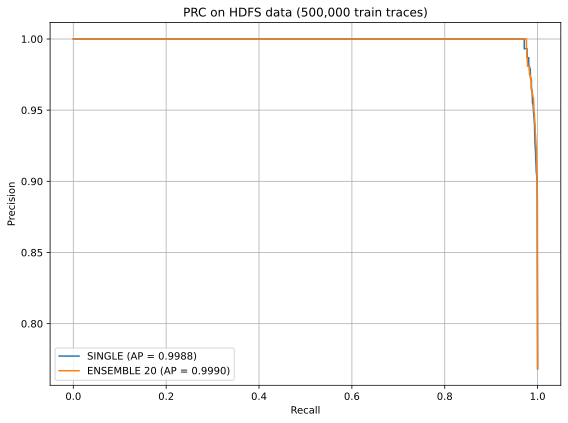

In [38]:
prediction_files = [tm.get_output_file(HDFS_CONFIG()) for tm in tested_models[:-1]]
label_file = str(ff.FF_ROOT / "data" / "hdfs" / "hdfs_test.txt")

# Labels and predictions
labels = np.array(load_labels(label_file))
model_names = ["SINGLE", "ENSEMBLE 20"]
model_predictions = [load_predictions(file) for file in prediction_files]

plot_prc_curves(labels, model_predictions, model_names, title_suffix=" (500,000 train traces)")


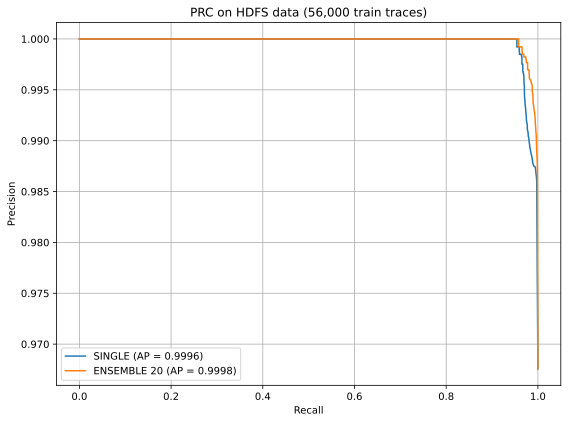

In [40]:
prediction_files = [tm.get_output_file(HDFS_CONFIG("_01")) for tm in tested_models[:-1]]
label_file = str(ff.FF_ROOT / "data" / "hdfs" / "hdfs_01_test.txt")

# Labels and predictions
labels = np.array(load_labels(label_file))
model_names = ["SINGLE", "ENSEMBLE 20"]
model_predictions = [load_predictions(file) for file in prediction_files]

plot_prc_curves(labels, model_predictions, model_names, title_suffix=" (56,000 train traces)")

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

def evaluate_predictions(y_true: list[int], y_pred: list[int], y_scores: list[float]) -> dict:
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "roc_auc": roc_auc_score(y_true, y_scores),
    }


def plot_roc_curves(y_true, probs_single, probs_ensemble):
    fpr_s, tpr_s, _ = roc_curve(y_true, probs_single, pos_label=0)
    fpr_e, tpr_e, _ = roc_curve(y_true, probs_ensemble, pos_label=0)

    auc_s = roc_auc_score(y_true, probs_single)
    auc_e = roc_auc_score(y_true, probs_ensemble)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr_s, tpr_s, label=f"Single model (AUC = {auc_s:.3f})", linewidth=2)
    plt.plot(fpr_e, tpr_e, label=f"Ensemble model (AUC = {auc_e:.3f})", linewidth=2)
    plt.plot([0, 1], [0, 1], "k--", label="Random baseline")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
